# Project - Twitter Trades

Group: Individual (Ying Chan)


Project Proposal:
The objective of this project would be to leverage tweets in Twitter related to individual stocks to analyze what factors attribute to each individual stock's movements (both up and down). With these factors, I am aiming to build an algorithm that can potentially flag potential up and down movements based on new tweets, and invest/capture this. A secondary objective would be to generate a return on this and benchmark this against a risk free rate or SPY (ETF for S&P 500) returns. 

Challenge:
This is an important and challenging concept as there are multiple strategies on the market which aims to "beat the market", though many were unable to do so. The hypothesis is that there might be too much noise within the market that might skew results, and the aim of the project is to explore this and hope to investigate on this matter.


Data Sources:
The data source will be Twitter tweets API in general. We will combine this data set with the stock price data obtained preferrably by the minute or 5-minute intervals. The stock return will be calculated and tagged against tweets.

Objective:
The ultimate objective is to create a natural language processing algorithm which will create feature extractions from tweets that help explain siginificant movement in stock prices. For example, certain tweets such as "price gouging" might affect a pharmaceutical drug stock. 

Evaluate:
The evaluation technique for this type of model is quite high given the nature of the project, which is to see if certain tweets will be able to predict future moves that are significant. For example, if a tweet relating to "drug price" against this stock (or even other stocks) that causes the model to predict a movement does indeed predict a movement. The magnitude of movement is not an important measure here, though the direction is important. Another metric that can be measured will be a model portfolio performance using this algorithm, whether it will "beat" a traditional risk free rate return.

Start with loading all stocks in the S&P 500 into a dataframe. 

In [5]:
snp500 = pd.read_csv('snp500.csv', header=0)

Load Tweepy library and start collecting search terms based on stocks in the S&P500. We start with a specific stock $RDUS for testing purposes of the algorithm. 

In [13]:
import tweepy
import csv
import pandas as pd

consumer_key="LX38iNoplbbMid20arGtsivQh"
consumer_secret="w1KQHobzm77FFdVMHIzHJJPPaPrHdx53e2Dq8CnuOwh0yr7luD"

access_token="268119650-HPK3lM3WSCnDAvl8d7PDmxwcWcRDC1XUZYr77doh"
access_token_secret="tu4UNdMdCWh0E7AuduS3EI2xliPSUv1TXTqPCj3NuglFb"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

For each stock in the S&P500 (we will limit to 300 first due to the Twitter API not allowing for more than a few hundred API calls per hour), we will search the Twitter API for tweets that are filtered by a "$" followed by the ticker symbol. The results are stored into a CSV file.

In [29]:
for i in range(0,100):
    ticker = snp500.loc[snp500.index[i], 'Ticker symbol']
    search_ticker = "$" + ticker
    csv_ticker = ticker + ".csv"
    
    #find the latest date for the last tweet stored for each stock
    #tweet_latest_date = pd.read_csv(csv_ticker, header=None)
    #date = pd.to_datetime(tweet_latest_date.tail(1)[0]).iloc[0]
    
    #query twitter api to obtain tweet results
    results = api.search(q=search_ticker, count=10000 , include_entities=True, lang="en", since_id=2016-11-11)

    #write to csv file and append new tweets
    with open(csv_ticker, 'wb') as csvfile:
        writer = csv.writer(csvfile)
        for result in results:
            writer.writerow([result.created_at, unicode(result.text).encode("utf-8") ])

In [6]:
#split into multiple loops to get around "Rate Limit Exceeded" error message on twitter api. Rerun after 1 hour.
for i in range(100, len(snp500)):
    ticker = snp500.loc[snp500.index[i], 'Ticker symbol']
    search_ticker = "$" + ticker
    csv_ticker = ticker + ".csv"
    
    #find the latest date for the last tweet stored for each stock
    #tweet_latest_date = pd.read_csv(csv_ticker, header=None)
    #date = pd.to_datetime(tweet_latest_date.tail(1)[0]).iloc[0]
    
    #query twitter api to obtain tweet results
    results = api.search(q=search_ticker, count=1000 , include_entities=True, lang="en", since_id=2016-11-11)

    #write to csv file and append new tweets
    with open(csv_ticker, 'wb') as csvfile:
        writer = csv.writer(csvfile)
        for result in results:
            writer.writerow([result.created_at, unicode(result.text).encode("utf-8") ])

We create a process tweet function to make all the words lower case and convert any hastags into normal words. This will help with pre-processing the tweet and improving the NLP model.

In [30]:
import re

#Perform basic pre-processing of tweet to improve our NLP model
def preprocess_tweet(tweet):
    #Lower case all words
    tweet = tweet.lower()
    #Remove URL strings
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #Remove double spacing
    tweet = re.sub('[\s]+', ' ', tweet)
    #Remove usernames
    tweet = re.sub('@[^\s]+','TWITTER_USER_NAME',tweet)
    #Remove hashtags
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    tweet = tweet.strip('\'"')
    #strip punctuation
    return tweet

Read CSV data from tweets and stocks to merge and append to dataframe. We also create a function to find the closest date and apply to existing panda dataframes to join the tweets data to the stock data. We keep the tweets data as the left dataframe as this is the data that is of interest. If there is no tweet, there is no need to observe stock data. We attempt to fit a traditional Gaussian Naive Bayes prediction model based on the occurence of words within the tweet to start, but will do so with individual models. We use the metric of accuracy (i.e. how many % the test data does the direction of the stock in the next 5 minute get predicted correctly) to assess the model for starter. 

In [47]:
import pandas as pd
import numpy as np

import re, nltk
from sklearn.feature_extraction.text import CountVectorizer        
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

def find_closest_date(timepoint, time_series, add_time_delta_column=True):
    deltas = np.abs(time_series - timepoint)
    idx_closest_date = np.argmin(deltas)
    res = {"closest_date": time_series.ix[idx_closest_date]}
    idx = ['closest_date']
    if add_time_delta_column:
        res["closest_delta"] = deltas[idx_closest_date]
        idx.append('closest_delta')
    return pd.Series(res, index=idx)

#Create functions for tokenize and stemming and the count vectorizer
stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    stop_words = 'english',
    max_features = 85
)

import nltk.data
tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')

indep_model_accuracy = []
indep_model_return = []

for i in range(0,100):
    ticker = snp500.loc[snp500.index[i], 'Ticker symbol']
    tweet_csv = ticker +'.csv'
    stock_csv = ticker +'.us.txt'
    tweets = pd.read_csv(tweet_csv, header=None)
    stocks = pd.read_csv(stock_csv)
    tweets.columns = ['timestamp', 'tweet']

    stocks['Timestamp'] = stocks.Date.astype(str).str.cat(stocks.Time.astype(str), sep=' ')

    #Convert to pandas date time format
    stocks['Timestamp'] = pd.to_datetime(stocks['Timestamp']) 
    tweets['timestamp'] = pd.to_datetime(tweets['timestamp']) 

    stocks['PreviousClose'] = stocks.Close.shift(1)
    stocks['Return'] = (stocks.Close/stocks.PreviousClose)-1
    
    tweets[['closest_timestamp', 'diff']] = tweets.timestamp.apply(
                                          find_closest_date, args=[stocks.Timestamp])

    combined = pd.merge(tweets, stocks, left_on=['closest_timestamp'], right_on=['Timestamp'])
    combined['Prediction_Class'] = np.where(combined['Return']>0, 'Up', 'Down')
    corpus_data_features = vectorizer.fit_transform(combined.tweet.tolist())
    corpus_data_features_nd = corpus_data_features.toarray()
    
    #Break out of loop if the stock does not have historical 
    if combined.Close.iloc[0]==combined.Close.iloc[len(combined)-1]:
        continue
    
    X_train, X_test, y_train, y_test  = train_test_split(
        corpus_data_features_nd[0:len(combined)], 
        combined.Prediction_Class,
        train_size=0.85)

    gnb_model = GaussianNB()
    gnb_model = gnb_model.fit(X=X_train, y=y_train)
    
    y_test_final = pd.Series.tolist(y_test)
    y_pred = gnb_model.predict(X_test)
    accuracy = accuracy_score(y_test_final, y_pred)
    
    stock_return = 1
    
    for i in (0, len(y_pred)-1):
        if y_pred[i] == "Up":
            stock_return = stock_return * (1 + combined['Return'][i])
    
    indep_model_return.append(stock_return)
    
    indep_model_accuracy.append(accuracy)
    #print "Ticker: %s, Accuracy: %f" % (ticker, accuracy)


Helper function created below to observe the occurence of words in the tweet. This will be useful for digging deeper into.

In [48]:
vocab = vectorizer.get_feature_names()
dist = np.sum(corpus_data_features_nd, axis=0)
for tag, count in zip(vocab, dist):
    print count, tag

4 activ
4 alert
6 amp
8 analysi
6 announc
4 aukz
4 b
4 bhi
6 board
4 bullish
6 chang
4 check
33 chesapeak
14 chesapeakeenergi
102 chk
18 corp
13 corpor
6 csco
4 dec
4 decemb
8 director
3 dwm
4 eca
33 energi
3 f
3 fb
7 fcx
8 firm
7 free
3 g
4 good
4 gvmdw
98 http
5 import
7 invest
5 investor
8 ladenburg
8 law
6 logo
4 look
9 m
7 market
6 mro
3 msft
10 new
4 news
3 nvda
3 o
7 oil
3 orcl
11 p
7 price
6 pt
3 qqq
7 rais
3 rbi
14 read
8 remind
3 rig
8 rosen
4 rpeahbzz
12 rt
14 s
5 sell
4 sentiment
7 share
12 stock
107 t
5 target
3 tech
8 thalmann
6 thi
4 time
4 tool
14 trade
4 unveil
3 uri
4 v
4 vale
4 video
6 week
4 weekend
7 weekli
6 wll
5 y


Plot histogram of the accuracy for each of the 500 stocks in S&P 500. Given the limitation of the Twitter API limiting the number of returns, we will not be able to asssess stocks that returns tweets only in the past few days (especially during weekends), as the stock price does not move. This resulted in stocks being predicted to go "Up", as our definiton of a stock price going up includes a flatline move. We plot this result in a histogram to see our assessment. 

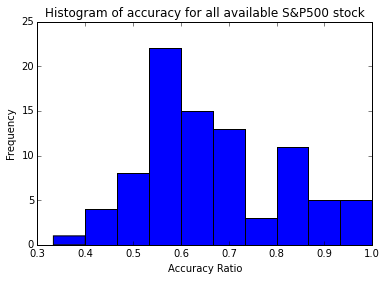

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(indep_model_accuracy)
plt.title("Histogram of accuracy for all available S&P500 stock")
plt.xlabel("Accuracy Ratio")
plt.ylabel("Frequency")
plt.show()

Although this provides one metric of accuracy, we also want to see the magnitude of each of the predictions although the model is not required to predict this. We will match the return for each of the accurate predictions, and provide the opposite return metric for the wrong prediction. We will first go with a long-short strategy (which means if the model predicts a down move, then the stock is shorted, providing a negative of the return during the time period). If the stock actually goes down (i.e. a correct prediction), then the resulting return will be positive and additive to returns. Otherwise, the counter is true. 

Below shows a histogram of the returns for the stocks in question above.

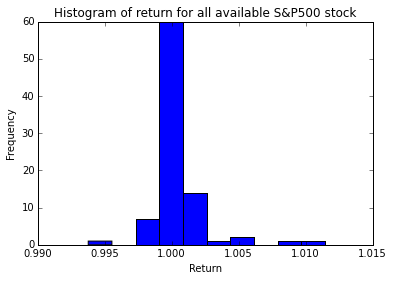

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(indep_model_return)
plt.title("Histogram of return for all available S&P500 stock")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()

Note that there is significant concentration around the 1.000 return range, i.e. meaning that there is no return. However, we need to keep in mind that we are looking at 5 minute interval data, and only within the test sample (15%) of any tweet. There appears to be some slight upward bias, which could potentially suggest that the model is performing to some degree (albeit tiny). We do not believe a test of significance of the average away from the zero (no return) to be relevant for our case despite many financial literature. 